# 公司生命周期

## 加载模块

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import mstats
import statsmodels.api as sm
from numpy.lib.stride_tricks import as_strided as stride

## 读入文件

_Warning: `df_stock['SICCD'] == 'Z'` 的情况将值转换为 -1_

_Warning: `df_stock['DLRET'].isin(['S', 'P', 'T'])` 的情况将值转换为 nan_

_Warning: `df_stock['RET'] == 'C'` 的情况将值转换为 0_

In [2]:
df_stock = pd.read_csv('../data/stock-monthly.csv', dtype={'SICCD': object, 'DLRET': object, 'RET': object})
df_stock['SICCD'] = df_stock['SICCD'].replace('Z', -1).astype(int)
df_stock['DLRET'] = df_stock['DLRET'].replace(['S', 'P', 'T', 'A'], np.nan).astype(float)
df_stock['RET'] = df_stock['RET'].replace('C', 0.).astype(float)

In [3]:
df_acc = pd.read_csv('../data/accounting-monthly.csv')

In [4]:
df_factor = pd.read_csv('../data/F-F_Research_Data_5_Factors_2x3.csv', skiprows=3, nrows=738)
df_factor = df_factor.rename(columns={'Unnamed: 0': 'dint'})
df_factor['dint'] = df_factor['dint'].astype(int)

初步处理

In [5]:
coms = df_stock['PERMNO'].unique()
print(f'公司样本数: {coms.size}')
df_acc = df_acc[df_acc['PERMNO'].isin(coms)]
df_acc = df_acc.sort_values(by=['PERMNO', 'MthCalDt'])

df_stock['date'] = pd.to_datetime(df_stock['date'])
df_acc['MthCalDt'] = pd.to_datetime(df_acc['MthCalDt'])
df_acc['datadate'] = pd.to_datetime(df_acc['datadate'])

time_series = df_stock['date'].unique()
time_series = np.sort(time_series)
df_time = pd.DataFrame({'date': time_series})
df_time['dint'] = df_time['date'].dt.year * 100 + df_time['date'].dt.month
df_factor = pd.merge(
    df_time,
    df_factor,
    on='dint',
    how='left'
)

公司样本数: 17775


## 定义公司周期

_Warning: 等于 0 的现金流按照大于 0 处理_

In [6]:
def life_cycle_stage(acc):
    '''
    根据现金流符号定义公司周期阶段
    acc: accounting information
    oancf: 经营活动现金流
    ivncf: 投资活动现金流
    fincf: 筹资活动现金流
    等于 0 的现金流按照大于 0 处理
    '''
    map_oif_2_stg = {(-1, -1, 1): 'Intro', (1, -1, 1): 'Growth', (1, -1, -1): 'Mature',
                     (-1, -1, -1): 'Shakeout', (1, 1, 1): 'Shakeout', (1, 1, -1): 'Shakeout',
                     (-1, 1, 1): 'Decline', (-1, 1, -1): 'Decline'}
    oif = np.sign([acc['oancf'], acc['ivncf'], acc['fincf']])
    # if (np.any(np.isnan(oif))):
    #     return 'Unknown'
    # oif[np.where(oif == 0.)] = 1.
    if np.any(np.isnan(oif)) or np.any(oif == 0):
        return 'Unknown'
    return map_oif_2_stg[tuple(oif)]

In [7]:
df_acc['stg'] = df_acc.apply(life_cycle_stage, axis=1)

### EXHIBIT2

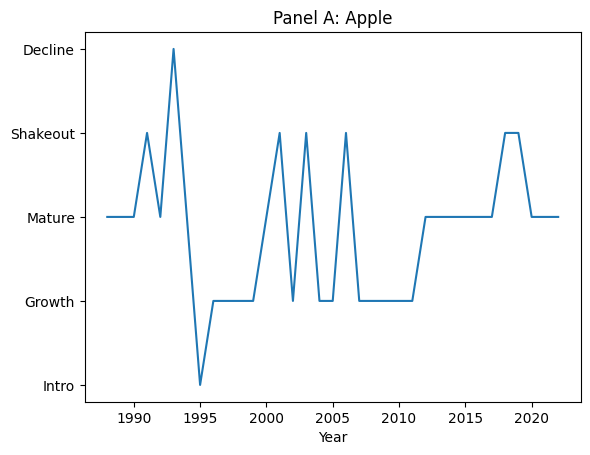

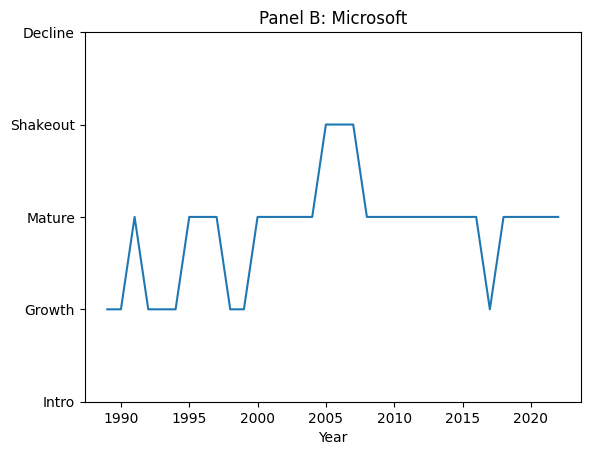

In [8]:
accounting_year = np.arange(1987, 2023)
index_stg = ['Intro', 'Growth', 'Mature', 'Shakeout', 'Decline']
map_stg_2_num = {stg: num for stg, num in zip(index_stg, range(5))}

stg_apple = df_acc[df_acc['conm'] == 'APPLE INC'].groupby('fyear')
stg_apple = stg_apple.first().loc[1987: 2023, 'stg']
stg_microsoft = df_acc[df_acc['conm'] == 'MICROSOFT CORP'].groupby('fyear')
stg_microsoft = stg_microsoft.first().loc[1987: 2023, 'stg']
stg_num_apple = stg_apple.apply(map_stg_2_num.get)
stg_num_microsoft = stg_microsoft.apply(map_stg_2_num.get)

plt.plot(accounting_year, stg_num_apple)
plt.gca().set_yticks(range(5))
plt.gca().set_yticklabels(index_stg)
plt.xlabel('Year')
plt.title('Panel A: Apple')
plt.savefig('../exhibits/Exhibit2-PanelA.png')
plt.show()

plt.plot(accounting_year, stg_num_microsoft)
plt.gca().set_yticks(range(5))
plt.gca().set_yticklabels(index_stg)
plt.xlabel('Year')
plt.title('Panel B: Microsoft')
plt.savefig('../exhibits/Exhibit2-PanelB.png')
plt.show()

## 计算公司特征量

### 计算市值

首先还需要对退市股价、退市收益率进行处理

需要注意 'PRC' 有正负号，需要取绝对值

| variable    | unit     |
|-------------|----------|
| PRC         | 1        |
| SHROUT      | thousand |
| RET         | 1        |
| market-cap  | billion  |
| past-return | 1        |

In [9]:
df_stock['CFACPR'] = df_stock['CFACPR'].replace(0, np.nan)
df_stock['CFACPR'] = df_stock['CFACPR'].ffill()
idx_prc_na = df_stock['PRC'].isna()
df_stock['adj-prc'] = 0

df_stock['adj-prc'] = df_stock['PRC'].apply(abs)# / df_stock['CFACPR']
df_stock.loc[idx_prc_na, 'adj-prc'] = df_stock.loc[idx_prc_na, 'DLPRC'].apply(abs)
df_stock.loc[idx_prc_na, 'RET'] = df_stock.loc[idx_prc_na, 'DLRET']

df_stock['market-cap'] = df_stock['adj-prc'] * df_stock['SHROUT'] * 1e3 / 1e9

### 计算历史收益率 

In [10]:
def past_return_calc(ret):
    growth_log = (1 + ret).apply(np.log)
    growth_log_11 = growth_log.shift(2).rolling(window=11).sum()
    return np.exp(growth_log_11) - 1

df_stock['past-return'] = df_stock.groupby('PERMNO', group_keys=False)['RET'].apply(past_return_calc)

## 计算 beta

估计最大可能保留的数据行数

`Pandas.DataFrame.rolling.apply()` 不能多列返回多列，故使用网友提供的自建 `roll()` 函数

来源：[DataFrame rolling apply 多列 return 多列](https://zhuanlan.zhihu.com/p/91100281)

In [11]:
def roll_np(df: pd.DataFrame, apply_func: callable, window: int,
         return_col_num: int, **kwargs):
    v = df.reset_index().values
    dim0, dim1 = v.shape
    stride0, stride1 = v.strides

    stride_values = stride(v, (dim0 - (window - 1), window, dim1), (stride0, stride0, stride1))
    result_values = np.full((dim0, return_col_num), np.nan)
    for idx, values in enumerate(stride_values, window - 1):
        result_values[idx, ] = apply_func(values, **kwargs)

    return result_values

定义函数：`beta` 回归、滚动窗口回归

In [12]:
def beta_reg_np(df_stock):
    '''
    df_stock 至少需要包含列: ['RET-RF', 'Mkt-RF']
    '''
    x = df_stock[:, 2]
    y = df_stock[:, 1]
    if (np.any(np.isnan(x)) or np.any(np.isnan(y))):
        return np.nan
    else:
        x = np.column_stack([np.ones(x.size), x])
        result = sm.OLS(y, x).fit()
        return result.params[1]

def rolling_reg_np(df_stock):
    '''
    df_stock 至少需要包含列: ['RET-RF', 'Mkt-RF']
    '''
    dfs = df_stock.copy()
    if dfs.shape[0] < 60:
        return pd.Series(np.nan, index=dfs.index, name='beta')
    else:
        result_np = roll_np(df=dfs[['RET-RF', 'Mkt-RF']].shift(1),
                            apply_func=beta_reg_np, window=60, return_col_num=1)
        result_np = result_np.T[0]
        return pd.Series(result_np, index=dfs.index, name='beta')

计算 `beta`

In [13]:
df_stock = pd.merge(
    df_stock,
    df_factor[['date', 'Mkt-RF', 'RF']],
    on='date', how='left'
)
df_stock[['Mkt-RF', 'RF']] *= 0.01

In [14]:
%%time
df_stock['RET-RF'] = df_stock['RET'] - df_stock['RF']
df_beta = df_stock.groupby('PERMNO')[['RET-RF', 'Mkt-RF']].apply(rolling_reg_np).reset_index()

CPU times: total: 3min 9s
Wall time: 3min 10s


In [15]:
df_stock['beta'] = df_beta['beta']

### 计算账面权益、盈利能力、投资水平、债务权益比

填补缺失值

_Warning: 如果 `pstkl`, `pstk` 都缺失，则把 `pstkrv` 替换为 0_

_Warning: 把所有参与计算的缺失值都替换为 0_

| variable      | unit               |
|---------------|--------------------|
| at            | million -> billion |
| txdb          | million            |
| pstkrv        | million            |
| pstkl         | million            |
| pstk          | million            |
| teq           | million            |
| revt          | million            |
| cogs          | million            |
| xsga          | million            |
| tie           | million            |
| book-equity   | million -> billion |
| debt-to-quity | 1                  |
| profit        | million            |
| investment    | million            |

In [16]:
df_acc['txdb'] = df_acc['txdb'].fillna(0)
df_acc['pstkrv'] = df_acc['pstkrv'].fillna(df_acc['pstkl'])
df_acc['pstkrv'] = df_acc['pstkrv'].fillna(df_acc['pstk'])
df_acc['pstkrv'] = df_acc['pstkrv'].fillna(0)
df_acc['teq'] = df_acc['teq'].fillna(df_acc['pstk'] + df_acc['ceq'])
df_acc['teq'] = df_acc['teq'].fillna(df_acc['at'] - df_acc['lt'])

df_acc[['lt', 'revt', 'cogs', 'xsga', 'tie', 'at']] = df_acc[['lt', 'revt', 'cogs', 'xsga', 'tie', 'at']].fillna(0)

In [17]:
df_acc['book-equity'] = (df_acc['teq'] - df_acc['pstkrv'] + df_acc['txdb'])
df_acc.loc[df_acc['book-equity'] <= 0, 'book-equity'] = np.nan
df_acc['debt-to-equity'] = df_acc['lt'] / df_acc['teq']
df_acc['profit'] = (df_acc['revt'] - df_acc['cogs']
                    - df_acc['xsga'] - df_acc['tie']) / df_acc['book-equity']
df_investment = df_acc.groupby(['PERMNO', 'fyear'])['at'].first().diff().reset_index()
df_investment = df_investment.rename(columns={'at': 'investment'})
df_acc = pd.merge(
    df_acc,
    df_investment,
    on=['PERMNO', 'fyear'],
    how='left'
)
df_acc[['at', 'book-equity', 'investment']] = df_acc[['at', 'book-equity', 'investment']] / 1e3

### 合并 `df_stock` 与 `df_acc`

~~使用 6 个月以前的最新的财报数据~~

~~_Warning: 公司在 1989 年的前几个月，可能没有 6 个月前的财报数据，通过采用表格中最老的数据 (1988 年) 来解决。比较好的解决方法可能是下载从 1987 开始的数据_~~

~~使用股票数据时间年份 - 1 年的财报数据~~

~~注意：`df_acc` 中，存在一个财年两份财报的状况，暂时保留全部两份，可以视情况采用后一份财报~~

使用数据库 CRSP/Compustat Merged - CRSP Stock Monthly with Compustat Fundamentals Annual 提供的现成对应关系

In [18]:
# df_stock['date_6_month'] = df_stock['date'] - pd.DateOffset(months=6)
# first_records = df_acc.groupby('LPERMNO').first()[['fyear', 'stg']]

# df_merge = pd.merge_asof(
#     df_stock.sort_values(['date_6_month']),
#     df_acc.sort_values(['datadate']),
#     left_on='date_6_month',
#     right_on='datadate',
#     left_by='PERMNO',
#     right_by='LPERMNO',
#     direction='backward'
# )
# mask = df_merge['fyear'].isna()
# df_merge.loc[mask, 'fyear'] = df_merge.loc[mask, 'PERMNO'].map(first_records['fyear'])
# df_merge.loc[mask, 'stg'] = df_merge.loc[mask, 'PERMNO'].map(first_records['stg'])

# df_merge = df_merge.sort_values(['PERMNO', 'date'])
# df_merge.loc[df_merge['PERMNO'] <= 10007, ['PERMNO', 'date', 'datadate', 'fyear', 'stg']]

In [19]:
df_merge = pd.merge(
    df_stock,
    df_acc,
    left_on=['PERMNO', 'date'],
    right_on=['PERMNO', 'MthCalDt'],
    how='left'
)
df_merge = df_merge.rename(columns={'SICCD_x': 'SICCD'})
# df_merge = df_merge[df_merge['book-equity'] >= 0]
# df_merge = df_merge.groupby(['PERMNO', "date"]).last().reset_index()

### 计算账面市值比

| variable       | unit |
|----------------|------|
| book-to-market | 1    |

In [20]:
df_merge['book-to-market'] = df_merge['book-equity'] / df_merge['market-cap']

### 保存新文件

In [21]:
reserved_columns = ['PERMNO', 'COMNAM', 'SICCD',
                    'date', 'fyear', 'stg', 'adj-prc', 'RET', 'RET-RF',
                    'beta', 'book-equity', 'profit', 'investment', 'past-return',
                    'market-cap', 'at', 'book-to-market', 'debt-to-equity']
idx = (df_merge['date'] >= '1989-01-31') & (df_merge['date'] <= '2022-12-30')
df_merge = df_merge.loc[idx, reserved_columns]
df_merge.to_csv('../data/stock-accounting.csv')

### EXHIBIT 4

In [22]:
def mean_wins(x):
    x_wins = x.dropna()
    x_wins = mstats.winsorize(x_wins, [0.01, 0.01])
    return x_wins.mean()
def std_wins(x):
    x_wins = x.dropna()
    x_wins = mstats.winsorize(x_wins, [0.01, 0.01])
    return x_wins.std()

sum_stat = ['market-cap', 'at', 'book-to-market', 'debt-to-equity',
            'profit', 'investment', 'past-return']
df_sum_stat = pd.DataFrame(columns=index_stg)
for ss in sum_stat:
    df_sum_stat.loc[ss + '-mean'] = df_merge.groupby('stg')[ss].apply(mean_wins)
    df_sum_stat.loc[ss + '-std'] = df_merge.groupby('stg')[ss].apply(std_wins)
df_sum_stat.to_csv('../exhibits/Exhibit4.csv')
pd.options.display.float_format = '{:.2f}'.format
df_sum_stat

,Intro,Growth,Mature,Shakeout,Decline
market-cap-mean,0.32,1.96,4.65,2.02,0.27
market-cap-std,0.83,5.57,14.80,7.10,0.70
at-mean,0.24,1.82,3.45,1.89,0.26
at-std,0.67,4.98,9.74,6.01,0.79
book-to-market-mean,0.66,0.65,0.70,0.88,0.77
book-to-market-std,0.85,0.66,0.68,0.95,0.92
debt-to-equity-mean,1.20,1.62,1.45,1.63,0.92
debt-to-equity-std,4.43,2.95,3.39,4.56,4.66
profit-mean,-0.50,0.30,0.39,0.15,-0.67
profit-std,1.46,0.32,0.47,0.55,1.46


## EXHIBIT 3

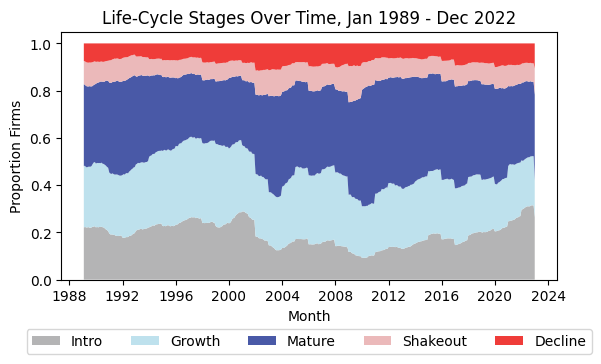

In [23]:
time_series = df_merge['date'].sort_values().unique()
df_frac = pd.DataFrame(time_series, columns=['date'])

count = df_merge[df_merge['stg'] != 'Unknown'].groupby('date').count()
df_frac['Total'] = df_frac['date'].map(count['stg'])
for stage in index_stg:
    stg_count = df_merge[df_merge['stg'] == stage].groupby('date').count()
    df_frac[stage] = df_frac['date'].map(stg_count['stg'])
    df_frac[stage] = df_frac[stage] / df_frac['Total']
frac_values = [df_frac[stage] for stage in index_stg]

colors = ['#b4b4b5', '#bee1ed', '#4959a7', '#ebb9ba', '#ef3c39']
plt.stackplot(time_series, frac_values, labels=index_stg, colors=colors)
plt.title('Life-Cycle Stages Over Time, Jan 1989 - Dec 2022')
plt.xlabel('Month')
plt.ylabel('Proportion Firms')
plt.gca().set_box_aspect(0.5)
plt.legend(ncols=5, loc=[-0.07, -0.3])
plt.savefig('../exhibits/Exhibit3.png')
plt.show()